In [1]:
outdir = '../output'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plot_tools as pt
import data_tools as dt

In [3]:
idx = pd.IndexSlice

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load Data

In [5]:
df_world = dt.load_country()

In [6]:
df_state = dt.load_state()

In [7]:
df_county = dt.load_county()

### Countries

In [8]:
world_names = {
    'USA': 'USA',
    'ITA': 'Italy',
    'DEU': 'Germany',
    'GBR': 'UK'
}

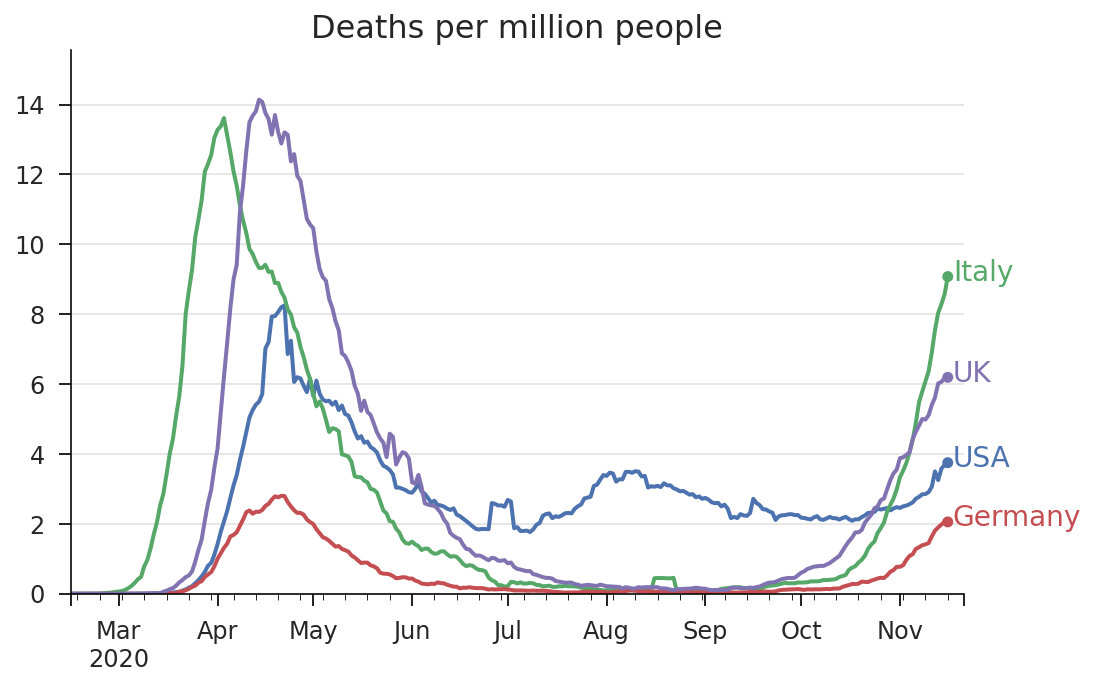

In [9]:
fig, ax = pt.plot_progress(df_world['deaths_pc'], names=world_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/country_deaths.svg', bbox_inches='tight')

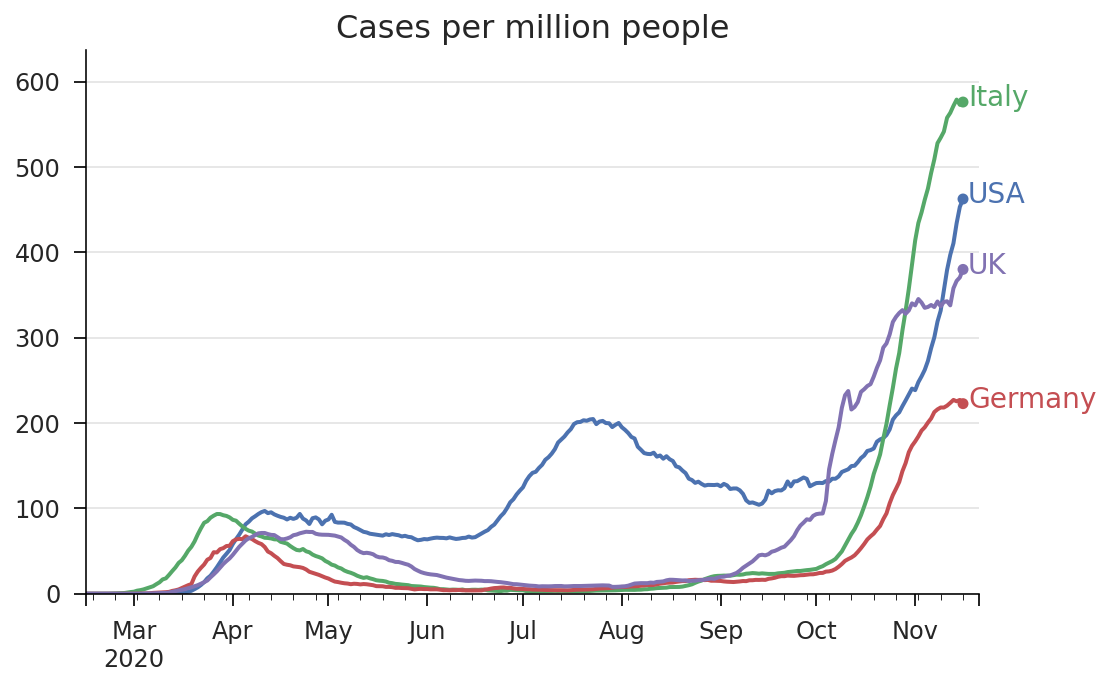

In [10]:
fig, ax = pt.plot_progress(df_world['cases_pc'], names=world_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/country_cases.svg', bbox_inches='tight')

### States

In [11]:
state_names = ['CA', 'PA', 'IL', 'WI', 'AZ']

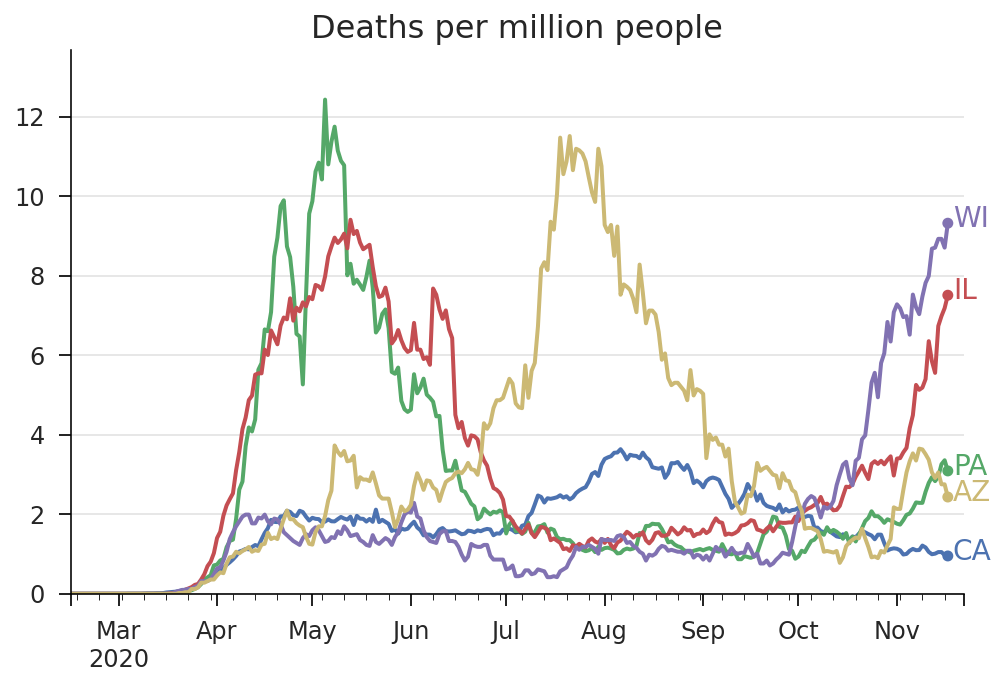

In [12]:
fig, ax = pt.plot_progress(df_state['deaths_pc'], names=state_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/state_deaths.svg', bbox_inches='tight')

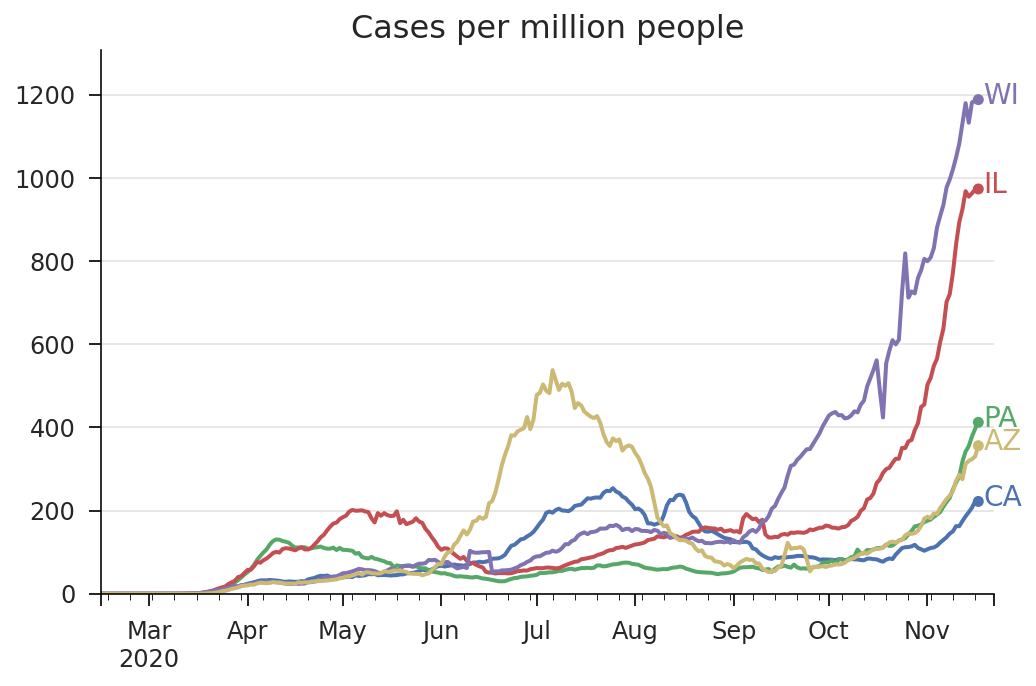

In [13]:
fig, ax = pt.plot_progress(df_state['cases_pc'], names=state_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/state_cases.svg', bbox_inches='tight')

### Counties

In [14]:
county_names = [
    'Los Angeles, CA',
    'Allegheny, PA',
    'Erie, NY',
    'King, WA',
    'Philadelphia, PA'
]

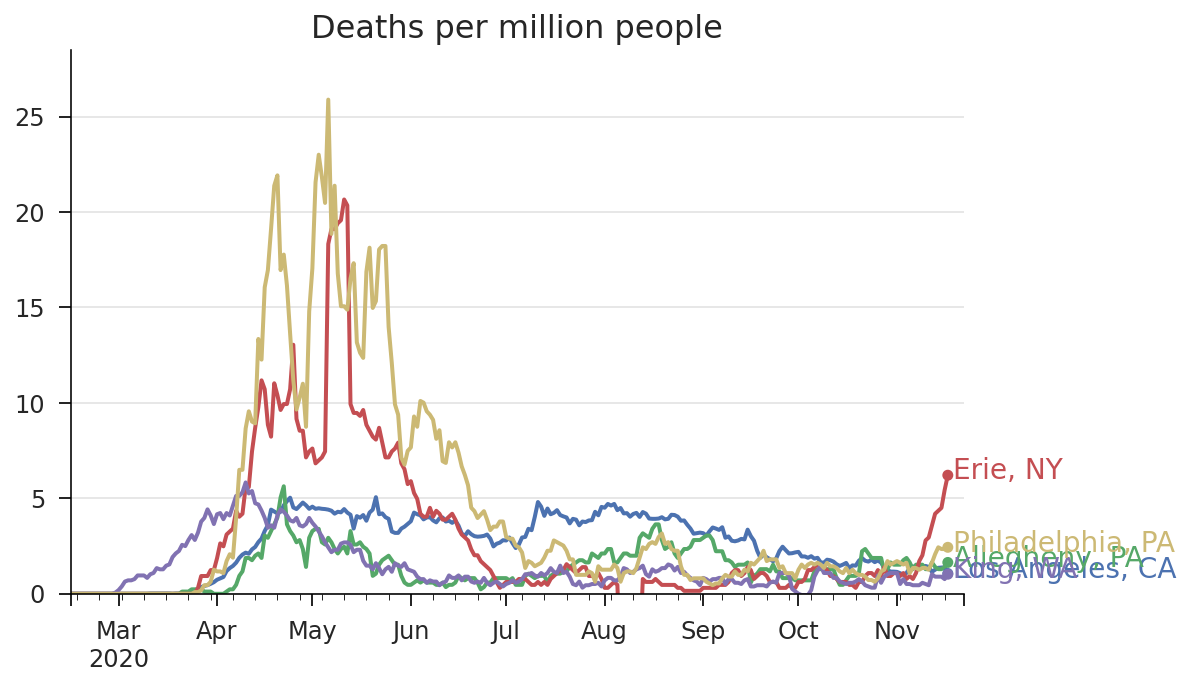

In [15]:
fig, ax = pt.plot_progress(df_county['deaths_pc'], names=county_names)
ax.set_xlabel('')
ax.set_title(f'Deaths per million people')
fig.savefig(f'{outdir}/county_deaths.svg', bbox_inches='tight')

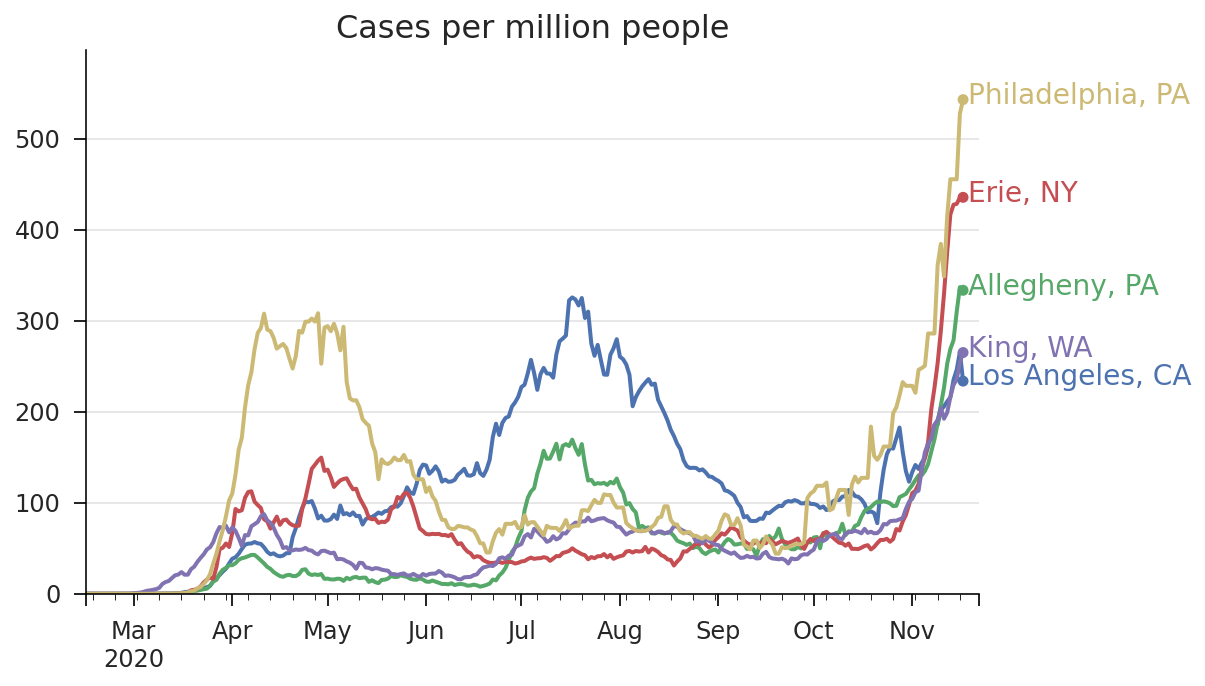

In [16]:
fig, ax = pt.plot_progress(df_county['cases_pc'], names=county_names)
ax.set_xlabel('')
ax.set_title(f'Cases per million people')
fig.savefig(f'{outdir}/county_cases.svg', bbox_inches='tight')

### EU

In [17]:
eu_codes = [
    'AUS', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST',
    'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA',
    'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK',
    'SVN', 'ESP', 'SWE'
]
df_eu = df_world.loc[:, idx[:, eu_codes]]

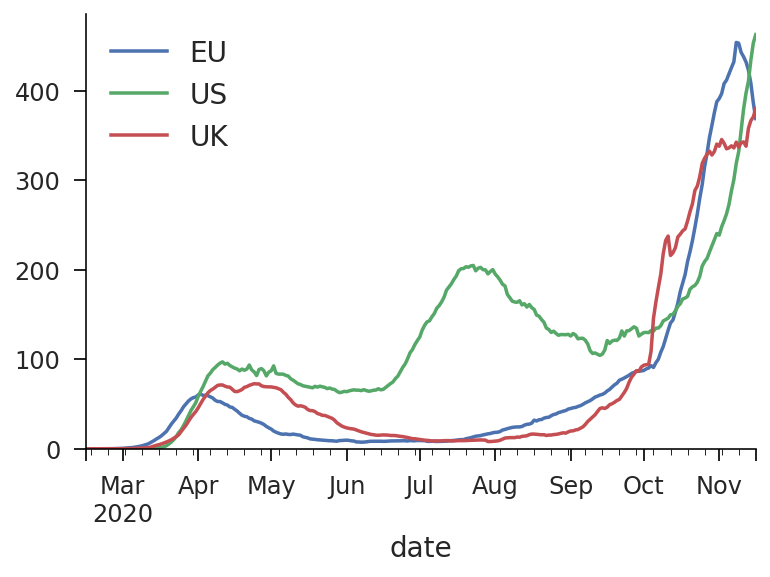

In [18]:
df_cases = pd.DataFrame({
    'EU': df_eu['cases'].sum(axis=1)/df_eu['pop'].sum(axis=1),
    'US': df_world['cases_pc']['USA'],
    'UK': df_world['cases_pc']['GBR']
})
(1e6*df_cases).rolling(7).mean().loc['2020-02-15':].plot(ylim=(0, None));

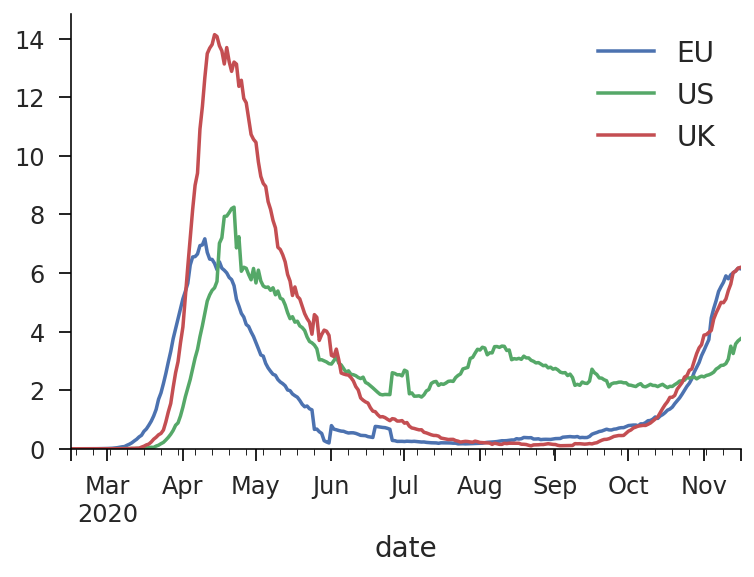

In [19]:
df_cases = pd.DataFrame({
    'EU': df_eu['deaths'].sum(axis=1)/df_eu['pop'].sum(axis=1),
    'US': df_world['deaths_pc']['USA'],
    'UK': df_world['deaths_pc']['GBR']
})
(1e6*df_cases).rolling(7).mean().loc['2020-02-15':].plot(ylim=(0, None));

### Testing

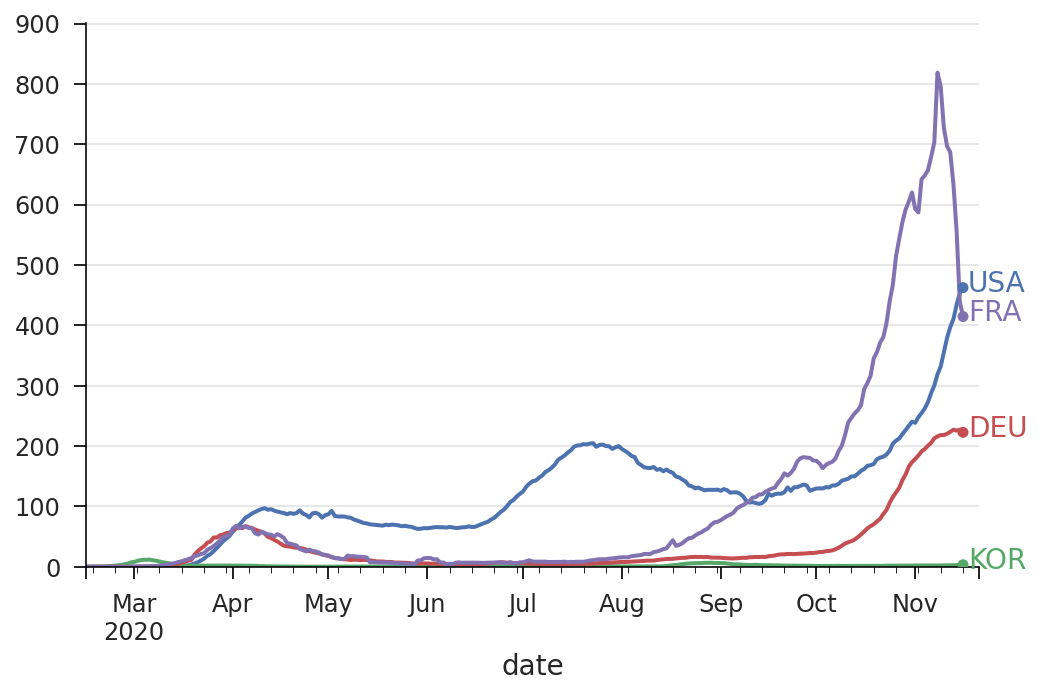

In [20]:
fig, ax = pt.plot_progress(df_world['cases_pc'], names=['USA', 'KOR', 'DEU', 'FRA'], per=1e6)

/media/wintermute/work/coviz/code/plot_tools.py:12: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)/np.log(base)


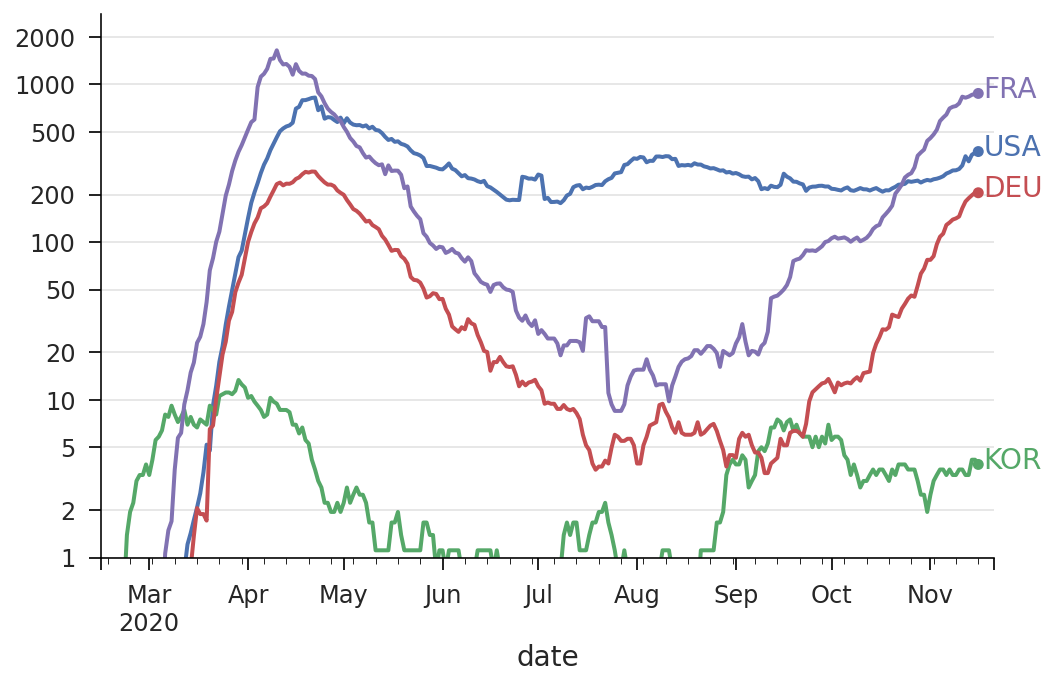

In [21]:
fig, ax = pt.plot_progress(df_world['deaths_pc'], names=['USA', 'KOR', 'DEU', 'FRA'], log=True, per=1e8)

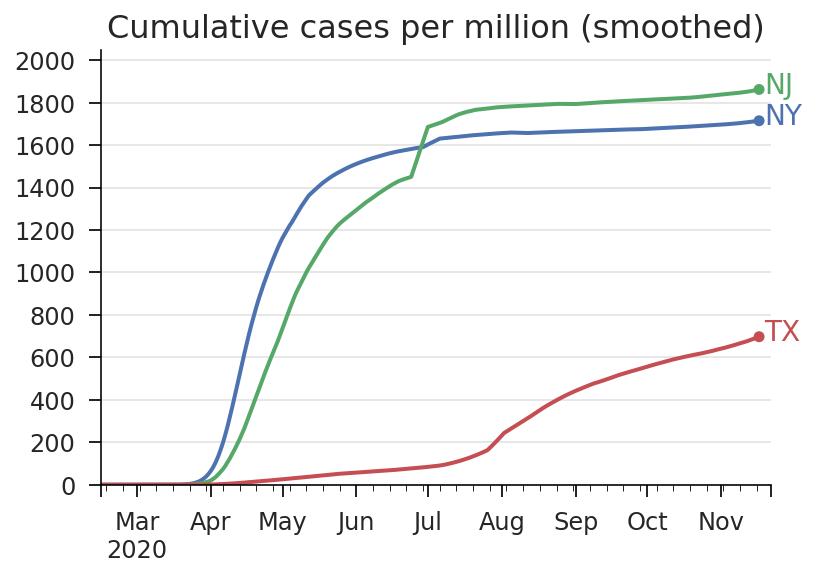

In [23]:
fig, ax = pt.plot_progress(
    df_state['deaths_pc'], names=['NY', 'NJ', 'TX'],
    log=False, cumul=True,
    per=1e6, figsize=(6, 4),
)
ax.set_xlabel('')
ax.set_title('Cumulative cases per million (smoothed)');
# fig.savefig(f'/home/doug/mountain_west.png', dpi=300, bbox_inches='tight')

## Tracker

In [45]:
strip_county = lambda s: s.removesuffix('County').removesuffix('Parish').strip()

In [46]:
county_stats = dt.load_county_stats()
county_stats['short_name'] = county_stats['county_name'].apply(strip_county)
county_stats['full_name'] = county_stats['short_name'] + ', ' + county_stats['state_code']
county_stats = county_stats.set_index('full_name')
county_stats = county_stats.drop('Oglala Lakota, SD')

In [63]:
case_smooth = df_county['cases_pc'].rolling(7).mean()
case_track = pd.DataFrame({
    'pop': county_stats['pop'],
    'state': county_stats['state_code'],
    'case_base': case_smooth.iloc[-15],
    'case_next': case_smooth.iloc[-1],
})
case_track['tot_base'] = case_track['pop']*case_track['case_base']
case_track['tot_next'] = case_track['pop']*case_track['case_next']
case_track['case_jump'] = (
    pt.log1(case_track['case_next'], base=10) - pt.log1(case_track['case_base'], base=10)
)
case_track['lpop'] = pt.log1(case_track['pop'].astype(np.float), base=10)

/home/doug/.local/lib/python3.9/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/doug/.local/lib/python3.9/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
state_grp = case_track.groupby('state')
state_track = state_grp[['tot_base', 'tot_next']].sum().div(state_grp['pop'].sum(), axis=0)
state_track['tot_jump'] = pt.log1(state_track['tot_next'], base=10) - pt.log1(state_track['tot_base'], base=10)

/home/doug/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


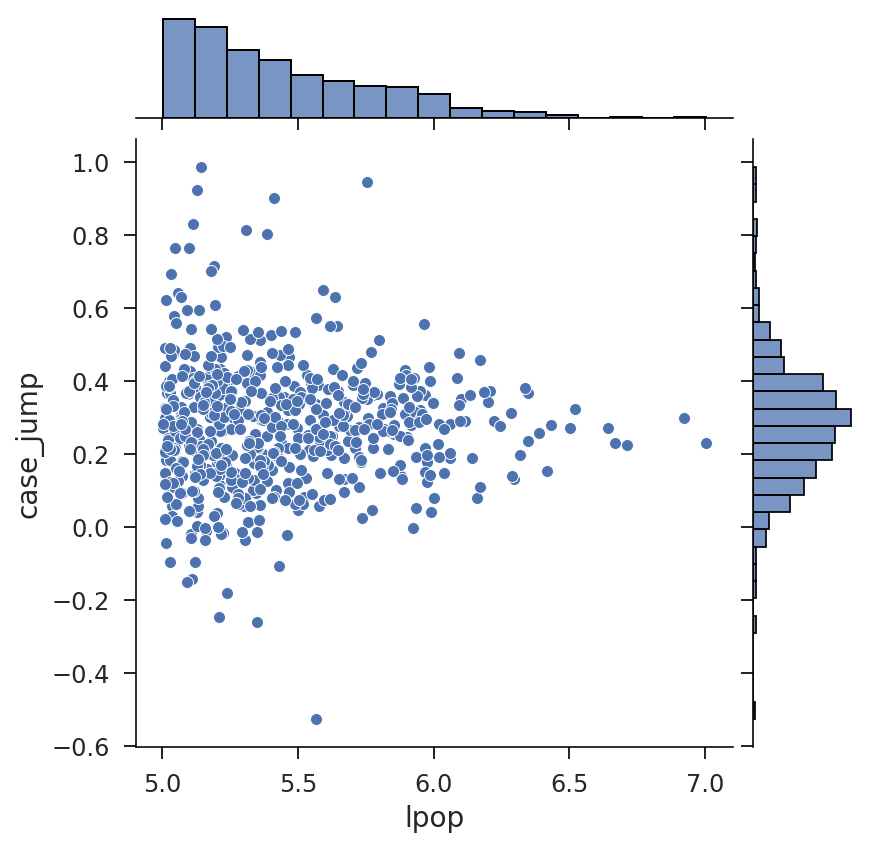

In [65]:
case_sel = case_track.query('pop > 100000')
sns.jointplot('lpop', 'case_jump', data=case_sel);

In [66]:
case_track.query('pop > 200000')['case_jump'].sort_values(ascending=False).head(30)

Williamson, TX          0.944697
St. Tammany, LA         0.901306
Calcasieu, LA           0.815260
Lafayette, LA           0.803796
Orleans, LA             0.648745
Jefferson, LA           0.630556
Mercer, NJ              0.573939
Erie, NY                0.557357
East Baton Rouge, LA    0.550473
Hillsborough, NH        0.549937
Webb, TX                0.538234
Lorain, OH              0.535642
Whatcom, WA             0.533603
Cumberland, PA          0.525627
Niagara, NY             0.515507
Lake, OH                0.512495
Bucks, PA               0.511707
Gloucester, NJ          0.487698
Montgomery, TX          0.479420
Cuyahoga, OH            0.478150
Harford, MD             0.477800
Erie, PA                0.471744
York, ME                0.471369
Dutchess, NY            0.465140
Suffolk, NY             0.456867
Smith, TX               0.453542
Summit, OH              0.449014
Somerset, NJ            0.445555
Ingham, MI              0.444316
Mahoning, OH            0.442666
Name: case

In [67]:
state_track = case_track.groupby('state')[['tot_base', 'tot_next']].sum()
(state_track['tot_next']/state_track['tot_base']).sort_values(ascending=False)

state
VT    5.227642
LA    4.761048
NH    2.466224
MN    2.418730
OK    2.249291
WA    2.233062
PA    2.226026
NJ    2.186800
OH    2.178007
NY    2.170101
MD    2.169661
ME    2.118506
MA    2.106477
CO    2.090322
WV    2.081053
DE    2.071368
TN    2.042186
CA    1.994115
IN    1.990630
KS    1.930754
CT    1.919987
MI    1.880991
IA    1.863181
NV    1.861359
MO    1.861265
WY    1.852471
NE    1.849234
AZ    1.842301
DC    1.838188
IL    1.831688
OR    1.830448
UT    1.744245
NM    1.649152
AR    1.570278
MS    1.566844
RI    1.512594
KY    1.509569
ID    1.506429
AL    1.504530
TX    1.495680
FL    1.484051
WI    1.429633
MT    1.427069
SC    1.378272
GA    1.365577
VA    1.278317
NC    1.252711
SD    1.238595
ND    1.193372
AK    1.188164
HI    1.078695
dtype: float64